In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import timedelta

# sns.set( style = 'darkgrid' )

# Data Cleaning and Visualization

In [34]:
df = pd.read_csv( './Sensado_Vestidores_Completo.csv', encoding = 'ISO-8859-1', parse_dates = [ 'Fecha' ] )
df.columns = [ 'Date', 'Pre', 'Alt', 'Hum', 'Temp', 'Occ' ]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10136 entries, 0 to 10135
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10136 non-null  object 
 1   Pre     10136 non-null  float64
 2   Alt     10136 non-null  float64
 3   Hum     10133 non-null  float64
 4   Temp    10136 non-null  float64
 5   Occ     10136 non-null  object 
dtypes: float64(4), object(2)
memory usage: 475.2+ KB


## Filling null values

In [35]:
len( df ) - df.count()

Date    0
Pre     0
Alt     0
Hum     3
Temp    0
Occ     0
dtype: int64

In [36]:
df[ 'Hum' ].fillna( method ='ffill', inplace = True )
len( df ) - df.count()

Date    0
Pre     0
Alt     0
Hum     0
Temp    0
Occ     0
dtype: int64

## Transforming to 10 seconds intervals

In [38]:
# generating the dataset in 10s intervals

def agg_date( col ):
    return col.iloc[ 0 ] # left labeling

def agg_occupancy( col ): 
    return col.mode()[ 0 ]

aggregations = [ 'mean', ] #'std', pd.DataFrame.kurt ]
df_10 = df.groupby( np.arange( len( df ) ) // 10 ).agg( { 
    'Date': agg_date, 
    'Occ': agg_occupancy,
    'Pre': aggregations, 
    'Alt': aggregations, 
    'Hum': aggregations, 
    'Temp': aggregations } )

df_10.columns = [ c[ 0 ] + '_' + c[ 1 ] for c in df_10.columns ]

df_10 = ( df_10
    .rename( columns = { 'Date_agg_date': 'Date', 'Occ_agg_occupancy': 'Occ' } )
    .sort_values( by = 'Date' ).reset_index( drop = True ) )

df_10

,Date,Occ,Pre_mean,Alt_mean,Hum_mean,Temp_mean
0,2019-09-24 16:19:13\t,M,94962.537,543.719,57.696,28.274
1,2019-09-24 16:19:23\t,M,94962.731,543.701,57.205,28.278
2,2019-09-24 16:19:33\t,M,94963.181,543.662,57.272,28.279
3,2019-09-24 16:19:43\t,M,94961.070,543.846,57.414,28.280
4,2019-09-24 16:19:53\t,M,94959.870,543.955,57.481,28.284
...,...,...,...,...,...,...
1009,43732.51528,M,95318.394,512.541,53.724,28.984
1010,43732.51528,M,95317.852,512.588,53.789,28.968
1011,43732.51528,M,95318.736,512.513,53.822,28.973
1012,43732.51528,M,95318.863,512.500,53.826,28.991


## Visualization 

### Visualizing the complete dataset

In [39]:
from scipy.stats import pearsonr

def pearson_corr( x, y, **kws ):
    ( r, p ) = pearsonr( x, y )
    ax = plt.gca()
    ax.annotate( "r = {:.2f} ".format( r ),
                xy = (.1, .9), xycoords = ax.transAxes )

def make_patch_spines_invisible( ax ):
    ax.set_frame_on( True )
    ax.patch.set_visible( False )
    for sp in ax.spines.values():
        sp.set_visible( False )
        
def plot_env_vars( x, temp, hum, occ, title = 'Temperature, Humidity and Occupancy' ):
    fig, host = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
    
    par1 = host.twinx()
    par2 = host.twinx()

    par2.spines[ 'right' ].set_position( ( 'axes', 1.04 ) )
    make_patch_spines_invisible( par2 )
    par2.spines[ 'right' ].set_visible( True )
    
    g1,  = host.plot( x, temp, 'royalblue', label = 'Temp' )
    g2,  = par1.plot( x, hum, 'forestgreen', label = 'Hum' )
    g3,  = par2.plot( x, occ.replace( { 'L': 0, 'M':1, 'H':2 } ), 'lightcoral', label = 'Occ' )
    
    host.set_xlabel( 'Date' )
    host.set_ylabel( 'Temp')
    par1.set_ylabel( 'Hum' )
    par2.set_ylabel( 'Occ' )
    
    par2.set_ylim( 0, 10 )
    par2.yaxis.set_major_locator( plt.IndexLocator( base = 1, offset = 0 ) )
    host.xaxis.set_major_locator( plt.AutoLocator() )
    
    plots = [ g1, g2, g3 ]
    host.legend( plots, [ l.get_label() for l in plots ] )
    
    fig.autofmt_xdate()
    plt.title( title )
    plt.show()
    
def plot_single( x, y, name ):
    fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
    
    g, = plt.plot( df_10.Date.astype( str ), y, 'royalblue', label = name )
    
    ax.xaxis.set_major_locator( plt.AutoLocator() )
    ax.legend( [ g ], [ g.get_label() ] )
    ax.set_ylabel( name.capitalize() )
    
    fig.autofmt_xdate()
    plt.title( name.capitalize(), fontsize = 16 )
    plt.show()

/Users/Andree/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Andree/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


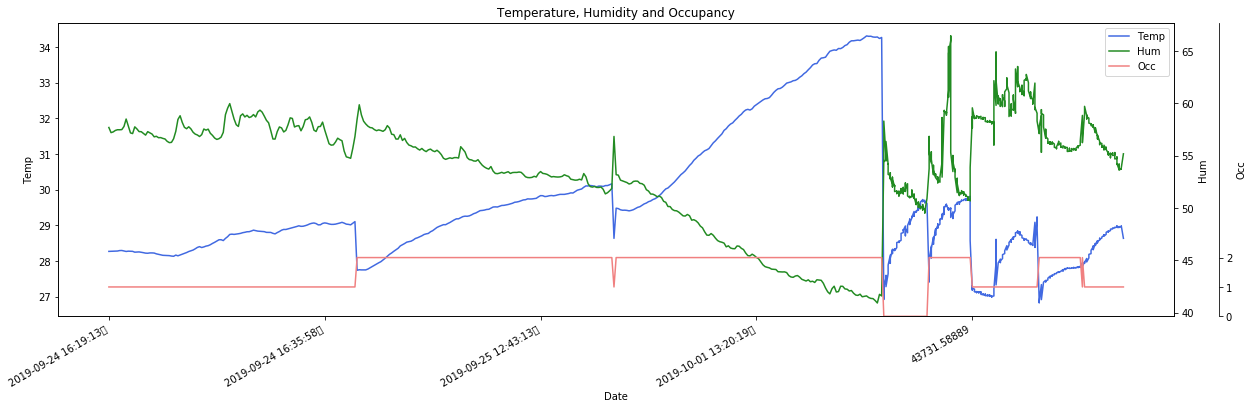

/Users/Andree/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Andree/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


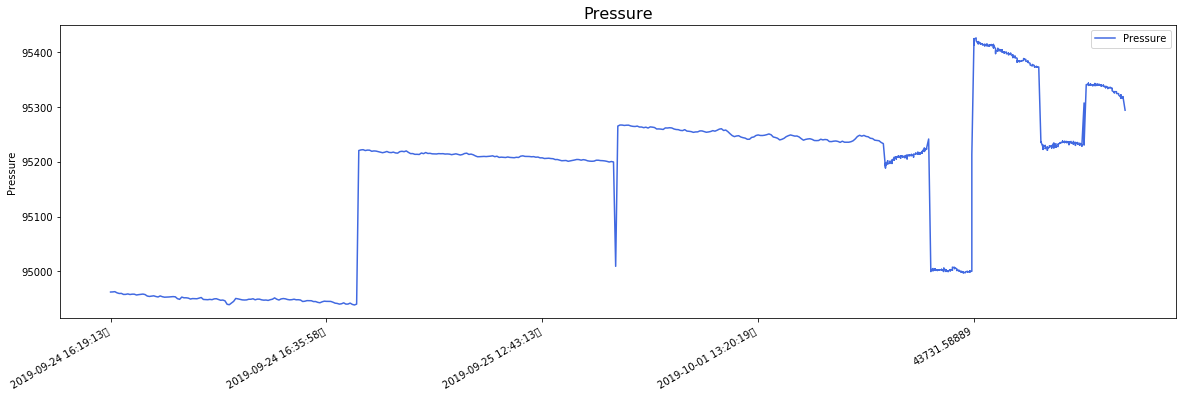

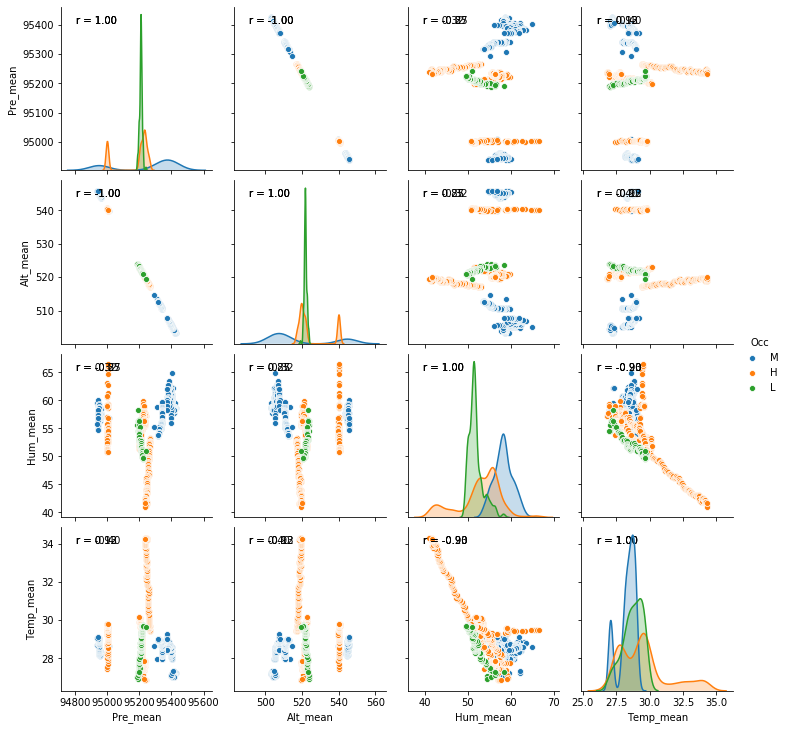

In [41]:
plot_env_vars( df_10.Date.astype( str ), df_10[ 'Temp_mean' ], df_10[ 'Hum_mean' ], df_10[ 'Occ' ] )
plot_single( df_10.Date.astype( str ), df_10[ 'Pre_mean' ], 'Pressure' )
g3 = sns.pairplot( df_10, hue = 'Occ', diag_kind = 'kde' )
g3.map( pearson_corr )

# Classificaton using averaged dataset

## Standarization

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split( 
    df_10.drop( [ 'Occ', 'Date' ], axis = 1 ), 
    df_10.Occ, 
    test_size = 3/10.0, 
    random_state = 0 )

scaler = StandardScaler()
scaler.fit( x_train )

x_train = scaler.transform( x_train )
x_test = scaler.transform( x_test )

## Classification

In [43]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm


def grid_search( estimator, params ):
    scoring = 'accuracy'
    cv_method = RepeatedStratifiedKFold( n_splits = 10, n_repeats = 2, random_state = 0 )
    
    return GridSearchCV( 
        estimator = estimator,
        param_grid = params,
        cv = cv_method,
        verbose = False,
        scoring = scoring,
        return_train_score = True )


def train_and_test( grid, x_train, y_train, x_test, y_test ):
    # Training 

    grid.fit( x_train, y_train );


    print( 'Best params: ', grid.best_params_ )
    print( 'Training Accuracy', grid.best_score_ )

    # Evaluation

    y_pred = grid.best_estimator_.predict( x_test )
    print( 'Test Accuracy: ', accuracy_score( y_test, y_pred ) )
    g = sns.heatmap( confusion_matrix( y_test, y_pred ), annot = True, cmap="YlGnBu" )
    g.set_title( 'Test Confussion Matrix' )

### SVM

Best params:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy 0.997867203219316
Test Accuracy:  0.9967213114754099


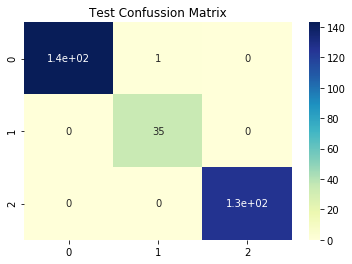

In [44]:
params_svc = [ { 
    'C': [ .1, 1, 10, 100 ], 
    'kernel': [ 'linear', 'poly' ] 
}, { 
    'C': [ .1, 1, 10, 100 ], 
    'kernel': [ 'rbf' ],
    'gamma': [ 10, 1, 0.1, 0.01, 0.001 ]
} ]

grid_svc = grid_search( svm.SVC(), params_svc )
train_and_test( grid_svc, x_train, y_train, x_test, y_test )

### KNN

Best params:  {'algorithm': 'brute', 'n_neighbors': 1, 'p': 1}
Training Accuracy 0.9985714285714288
Test Accuracy:  0.9967213114754099


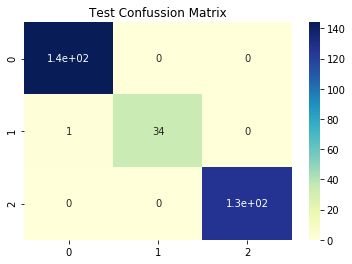

In [45]:
params_knn = { 
    'n_neighbors': [ 1, 3, 8, 13 ], 
    'p': [ 1, 2 ], # mikowsky distance
    'algorithm': [ 'brute', 'ball_tree', 'kd_tree' ]
}

grid_knn = grid_search( KNeighborsClassifier(), params_knn )
train_and_test( grid_knn, x_train, y_train, x_test, y_test )

### Decision Trees

Best params:  {'criterion': 'entropy', 'max_depth': 9}
Training Accuracy 0.9922233400402416
Test Accuracy:  0.9868852459016394


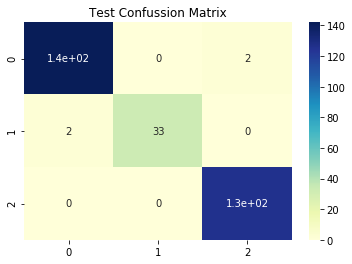

In [47]:
params_dt = { 
    'criterion': [ 'gini', 'entropy' ], 
    'max_depth': [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ]
}

grid_dt = grid_search( DecisionTreeClassifier(), params_dt )
train_and_test( grid_dt, x_train, y_train, x_test, y_test )

# PCA analysis

## Finding the components

In [48]:
from sklearn.decomposition import PCA

pca = PCA( .95 )
pca.fit( x_train )
print( "Number of components to explain 95% of variance is " + str( pca.n_components_ )  )

Number of components to explain 95% of variance is 3


In [49]:
x_train_pca = pca.transform( x_train )
x_test_pca = pca.transform( x_test )

columns = [ 'PCA_' + str( i ) for i in range( 1, pca.n_components_ + 1 ) ]
df_temp = pd.DataFrame( data = x_train_pca, columns = columns )
df_temp.set_index( y_train.index, drop = True, inplace = True )
df_temp = pd.concat( [ df_temp, y_train ], axis = 1 )
df_temp

,PCA_1,PCA_2,PCA_3,Occ
993,0.982368,0.614865,-0.035455,M
406,-0.142492,0.300662,-0.754736,L
643,2.473802,-0.132406,-0.413550,M
258,-0.176125,1.261578,-0.168047,H
644,2.469305,-0.112255,-0.417649,M
...,...,...,...,...
835,0.691904,-0.554760,-0.390198,H
192,-0.297446,0.522914,0.092159,H
629,2.495579,-0.146408,-0.363214,M
559,-2.098890,-0.426594,-0.162579,H


Text(0.5, 1.0, 'Variance explained by Component')

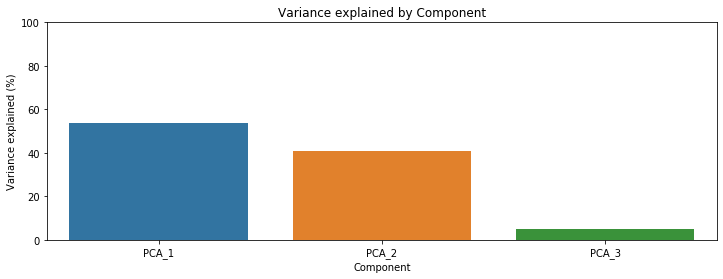

In [50]:
fig, ax = plt.subplots( 1, 1, figsize = ( 12, 4 ) )
plt.ylim( 0, 100 )
g = sns.barplot( x = columns, y = pca.explained_variance_ratio_ * 100 )
g.set_xlabel( 'Component' )
g.set_ylabel( 'Variance explained (%)' )
g.set_title( 'Variance explained by Component' )

## Classification using the PCA dataset

### SVM

Best params:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy 0.997867203219316
Test Accuracy:  0.9967213114754099


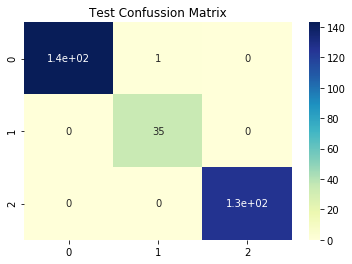

In [51]:
grid_svc_pca = grid_search( svm.SVC(), params_svc )
train_and_test( grid_svc_pca, x_train_pca, y_train, x_test_pca, y_test )

### K-NN

Best params:  {'algorithm': 'brute', 'n_neighbors': 1, 'p': 1}
Training Accuracy 0.9971629778672032
Test Accuracy:  0.9967213114754099


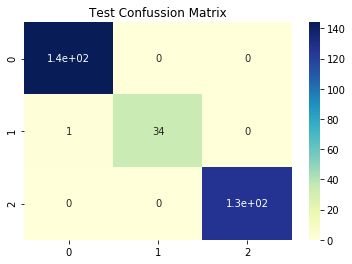

In [52]:
grid_knn_pca = grid_search( KNeighborsClassifier(), params_knn )
train_and_test( grid_knn_pca, x_train_pca, y_train, x_test_pca, y_test )

### Decision Trees

Best params:  {'criterion': 'gini', 'max_depth': 7}
Training Accuracy 0.995754527162978
Test Accuracy:  0.9868852459016394


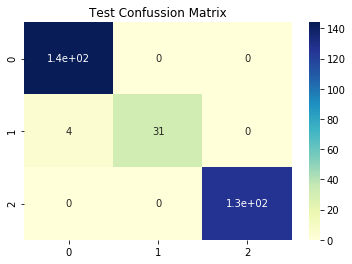

In [54]:
grid_dt_pca = grid_search( DecisionTreeClassifier(), params_dt )
train_and_test( grid_dt_pca, x_train_pca, y_train, x_test_pca, y_test )

# Class imbalance

## Balancing classes

In [55]:
from collections import Counter

Counter( y_train )

Counter({'M': 280, 'L': 86, 'H': 343})

In [56]:
from imblearn.over_sampling import ADASYN

oversample = ADASYN( sampling_strategy = 'not majority', n_neighbors = 40, random_state = 42 )

x_train_pca_balanced, y_train_balanced = oversample.fit_resample( x_train_pca, y_train )
print( Counter( y_train_balanced ) )

Counter({'L': 347, 'M': 346, 'H': 343})


In [57]:
df_temp = pd.DataFrame( data = x_train_pca_balanced, columns = columns )
df_temp = pd.concat( [ df_temp, pd.DataFrame( y_train_balanced ) ], axis = 1 )
df_temp

,PCA_1,PCA_2,PCA_3,Occ
0,0.982368,0.614865,-0.035455,M
1,-0.142492,0.300662,-0.754736,L
2,2.473802,-0.132406,-0.413550,M
3,-0.176125,1.261578,-0.168047,H
4,2.469305,-0.112255,-0.417649,M
...,...,...,...,...
1031,-1.751449,-1.835869,-0.063156,M
1032,-1.681815,-1.899910,-0.064523,M
1033,-1.796338,-1.843786,0.059659,M
1034,-1.762326,-1.812124,-0.122290,M


## Classification using balanced dataset

### SVM 

Best params:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy 0.9990337938760268
Test Accuracy:  0.9967213114754099


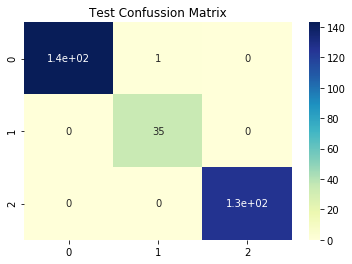

In [58]:
grid_svc_balanced = grid_search( svm.SVC(), params_svc )
train_and_test( grid_svc_balanced, x_train_pca_balanced, y_train_balanced, x_test_pca, y_test )

### KNN

Best params:  {'algorithm': 'brute', 'n_neighbors': 1, 'p': 1}
Training Accuracy 0.9990337938760268
Test Accuracy:  0.9934426229508196


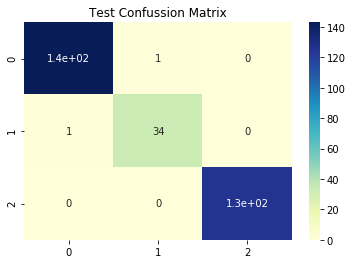

In [59]:
grid_knn_balanced = grid_search( KNeighborsClassifier(), params_knn )
train_and_test( grid_knn_balanced, x_train_pca_balanced, y_train_balanced, x_test_pca, y_test )

### Decision Trees

Best params:  {'criterion': 'gini', 'max_depth': 6}
Training Accuracy 0.9990384615384615
Test Accuracy:  0.9836065573770492


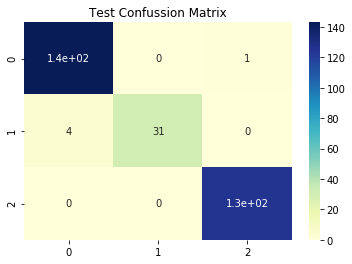

In [60]:
grid_dt_balanced = grid_search( DecisionTreeClassifier(), params_dt )
train_and_test( grid_dt_balanced, x_train_pca_balanced, y_train_balanced, x_test_pca, y_test )